## Sequentiel

On va créer une modele suivant sans utiliser l'autograd de PyTorch.

Lineaire --> Tanh --> Lineaire --> Sigmoid -> MSE



In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from Module import Lineaire
from losses import MSE, Hinge, CrossEntropy
from Function import Function
from tools import get_patches, pad_to_32
from activations import TanhActivation, SigmoidActivation
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sys


from load_data import get_train_test_loaders

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
train_loader,test_loader, train_size, test_size = get_train_test_loaders(batch_size=128)

In [4]:
def get_minibatches(loader):
    for data, target in loader:
        data = torch.squeeze(data)
        batch_n = data.size()[0]
        #
        #data.view(batch_n, -1)
        X = data.view(batch_n, -1)
        X = torch.cat((X, torch.ones((X.size()[0], 1))), 1)
        
        y = target.view(batch_n, 1).float()
        y[y == -1] = 0 # sigmoid entre 0 et 1
        #import pdb; pdb.set_trace()
        yield X.t(), y
        
def threshold(x):
    return torch.where(x < 0.5, torch.ones(1), torch.zeros(1))

In [5]:
torch.cuda.set_device(0)

layers_dims = [28*28 + 1, 128, 1]

epsilon = 1e-6

# lineaire->tanh->lineaire->sigmoide->MSE
lineaire1 = Lineaire(layers_dims[0], layers_dims[1])
activation1 = TanhActivation() # Tanh
lineaire2 = Lineaire(layers_dims[1], layers_dims[2])
activation2 = SigmoidActivation() # Sigmoid
loss = MSE()

func = Function()

W1 = torch.randn(layers_dims[1], layers_dims[0]) * 0.1
W2 = torch.randn(layers_dims[2], layers_dims[1]) * 0.1

train_errors = []
test_errors = []
accuracys = []

corrects_classified = torch.zeros(1)
train_error = -1
for epoch in range(40):
    if epoch % 5 == 0:
        print("Epoch {}".format(str(epoch)))
        print("Error {}".format(str(train_error)))
        print("Accuracy {}".format(str(corrects_classified.numpy()  / test_size)))
        print("NANS : {}".format(str(torch.isnan(W1).any())))
    
    epoch_train_errors = []
    for i,(X, y) in enumerate(get_minibatches(train_loader)):

        y_h1 = func.forward(W1, X)
        y_h2 = activation1.forward(y_h1) 
        
        y_h3 = func.forward(W2, y_h2)
        y_hat = activation2.forward(y_h3).view((X.size()[1], 1))
                
        train_error = loss.forward(y,y_hat)
        epoch_train_errors.append(train_error)
        
        dAL = loss.backward(y,y_hat) 
        
        dZ2 = activation2.backward(dAL, y_hat)
        dA2, dW2 = func.backward(W2, dZ2, y_h2)
        
        dZ1 = activation1.backward(dA2, y_h2)
        _, dW1 = func.backward(W1, dZ1.t(), X)
        
        W1 -= epsilon * dW1.t()
        W2 -= epsilon * dW2.t()
    
    train_errors.append(np.mean(epoch_train_errors))
    corrects_classified = 0
    epoch_test_error = []
    for i, (X, y) in enumerate(get_minibatches(test_loader)):
        a0 = X
        y_h1 = func.forward(W1, X) #s1
        y_h2 = activation1.forward(y_h1) #x1 layer1
        
        y_h3 = func.forward(W2, y_h2) #s2
        y_hat = activation2.forward(y_h3).view((X.size()[1], 1)) #x2 layer2
        yhat = threshold(y_hat)
        
        corrects_classified += torch.sum(y == yhat)
                
        test_error = loss.forward(y,y_hat)
        epoch_test_error.append(test_error)
    test_errors.append(np.mean(epoch_test_error))
    accuracys.append(corrects_classified.numpy() / test_size)

Epoch 0
Error -1
Accuracy [0.]
NANS : tensor(0, dtype=torch.uint8)
Epoch 5
Error tensor(0.3813)
Accuracy 0.6547572815533981
NANS : tensor(0, dtype=torch.uint8)
Epoch 10
Error tensor(0.3962)
Accuracy 0.7417475728155339
NANS : tensor(0, dtype=torch.uint8)
Epoch 15
Error tensor(0.4100)
Accuracy 0.8038834951456311
NANS : tensor(0, dtype=torch.uint8)
Epoch 20
Error tensor(0.4439)
Accuracy 0.8660194174757282
NANS : tensor(0, dtype=torch.uint8)
Epoch 25
Error tensor(0.5648)
Accuracy 0.8920388349514563
NANS : tensor(0, dtype=torch.uint8)
Epoch 30
Error tensor(0.6219)
Accuracy 0.9044660194174757
NANS : tensor(0, dtype=torch.uint8)
Epoch 35
Error tensor(0.6495)
Accuracy 0.9161165048543689
NANS : tensor(0, dtype=torch.uint8)
Epoch 40
Error tensor(0.7246)
Accuracy 0.9223300970873787
NANS : tensor(0, dtype=torch.uint8)
Epoch 45
Error tensor(0.7879)
Accuracy 0.926990291262136
NANS : tensor(0, dtype=torch.uint8)
Epoch 50
Error tensor(0.8184)
Accuracy 0.9332038834951456
NANS : tensor(0, dtype=torch.ui

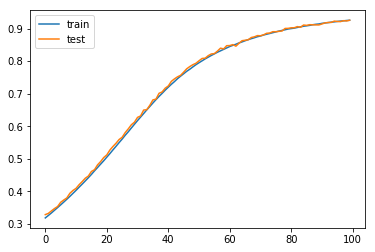

In [6]:
plt.plot(list(range(len(train_errors))), train_errors, label="train")
plt.plot(list(range(len(test_errors))), test_errors, label="test")
plt.legend()

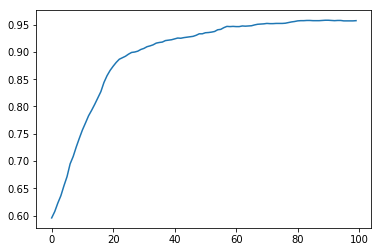

In [7]:
plt.plot(list(range(len(accuracys))), accuracys)

### Evaluation

Dans le classification binaire entre 1 et 3 on a arrivé jusqu'à accuracy de 0.957. 

On peut noter, que les images des uns sont bien détécte comme 1, si ils sont pointé vers droite . Par contre presque toutes les exemples du classe 1, qui sont mal classées, pointent vers gauche.

In [23]:
bad_classified_three = []
bad_classified_one = []
good_classified_three = []
good_classified_one = []

corrects = 0
test_error = 0
for i, (X, y) in enumerate(get_minibatches(test_loader)):
    a0 = X
    y_h1 = func.forward(W1, X) #s1
    y_h2 = activation1.forward(y_h1) #x1 layer1

    y_h3 = func.forward(W2, y_h2) #s2
    y_hat = activation2.forward(y_h3).view((X.size()[1], 1)) #x2 layer2
    yhat = threshold(y_hat)

    corrects += torch.sum(y == yhat)
    
    good_clf_1 = ((y == yhat) * (y == 1))
    if (good_clf_1 == 1).any():
        for column,val in enumerate(good_clf_1):
            if val == 1:
                good_classified_one.append(X[1:, column])
    good_clf_3 = ((y == yhat) * (y == 0))
    if (good_clf_1 == 1).any():
        for column,val in enumerate(good_clf_3):
            if val == 1:
                good_classified_three.append(X[1:, column])
    bad_clf_3 = ((y != yhat) * (y == 0))
    if (bad_clf_3 == 1).any():
        for column,val in enumerate(bad_clf_3):
            if val == 1:
                bad_classified_three.append(X[1:, column])
    bad_clf_1 = ((y != yhat) * (y == 1))
    if (bad_clf_1 == 1).any():
        for column,val in enumerate(bad_clf_1):
            if val == 1:
                bad_classified_one.append(X[1:, column])

print(corrects.numpy() / test_size)

0.9572815533980582


In [ ]:
def show_images(collection):
    w=28
    h=28
    fig=plt.figure(figsize=(8, 8))
    columns = 3
    rows = 3
    for i in range(1, columns*rows +1):
        img = collection[i].view(28,28)
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()

Les uns bien classifié.

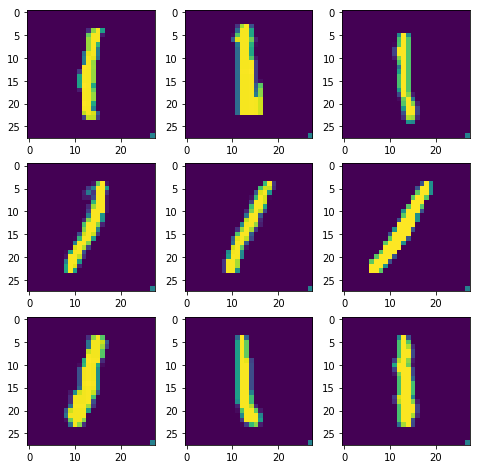

In [18]:
show_images(good_classified_one)

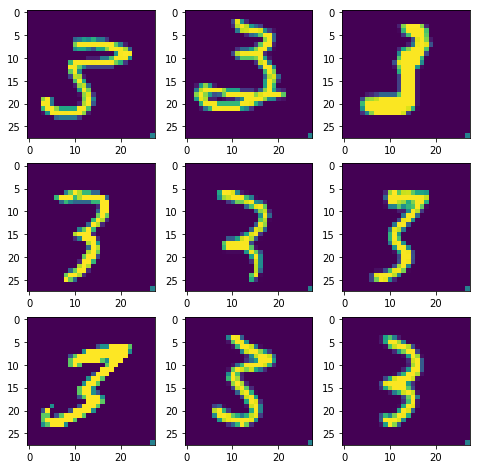

In [19]:
show_images(bad_classified_three)

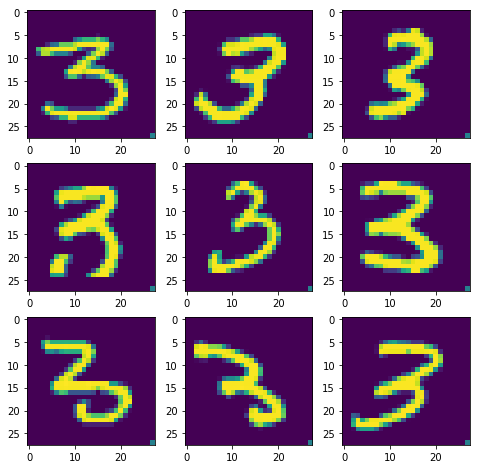

In [20]:
show_images(good_classified_three)

Les uns mal classifié.

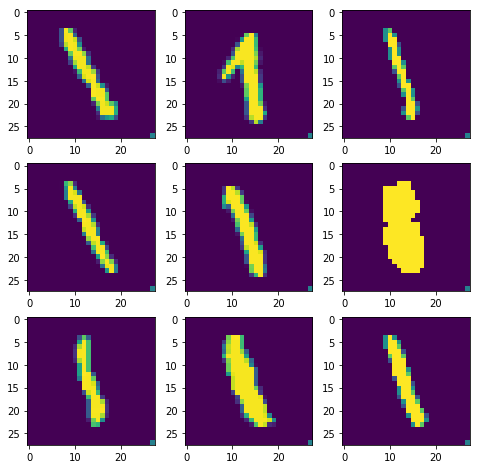

In [24]:
show_images(bad_classified_one)